In [1]:
import matplotlib as mpl

# Global font settings for all figures
mpl.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.titlesize": 18,
})

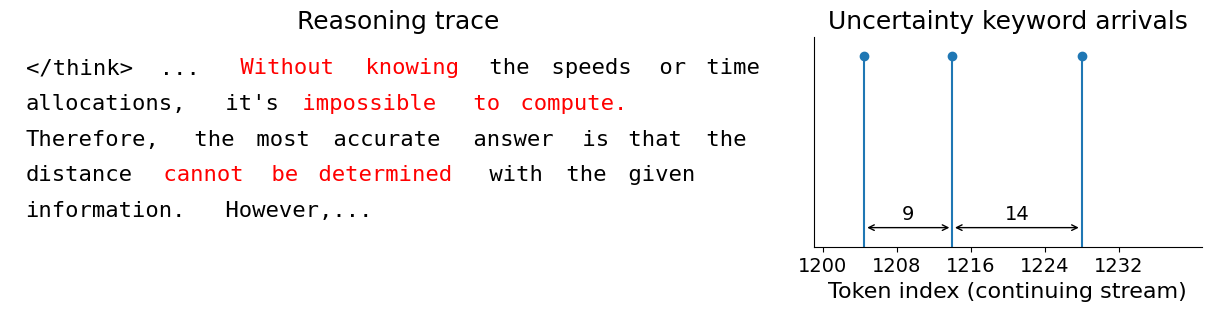

In [2]:
import re
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------
# 1. Example reasoning trace (you can replace this with any trace)
# ---------------------------------------------------------------------
text = (
    "... Without knowing the speeds or time allocations, it's impossible to compute. "
    "Therefore, the most accurate answer is that the distance cannot be determined "
    "with the given information. However, ..."
)

# Uncertainty keyword phrases
keyword_phrases = [
    "without knowing",
    "impossible to compute",
    "cannot be determined",
]

# ---------------------------------------------------------------------
# 2. Tokenization (keeps contractions like "it's" together)
# ---------------------------------------------------------------------
tokens = re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?|[0-9]+|[^\w\s]", text)
# Merge HTML-like tags
tokens = ["</think>  "] + tokens

tokens_lower = [t.lower() for t in tokens]
kw_tokens = {kw: kw.split() for kw in keyword_phrases}

# ---------------------------------------------------------------------
# 3. Simple keyword detection (no greedy longest-match)
# ---------------------------------------------------------------------
arrivals = []        # token indices (midpoints of matched phrases)
arrival_spans = []   # (start_idx, end_idx) for each phrase

i = 0
while i < len(tokens_lower):
    matched = False
    for kw, seq in kw_tokens.items():
        L = len(seq)
        if i + L <= len(tokens_lower) and tokens_lower[i:i + L] == seq:
            start, end = i, i + L
            arrival_spans.append((start, end))
            arrivals.append((start + end - 1) / 2)  # midpoint as "arrival time"
            i = end        # skip past this phrase
            matched = True
            break
    if not matched:
        i += 1

# ---------------------------------------------------------------------
# 4. Per-token uncertainty mask
# ---------------------------------------------------------------------
is_uncertain = [
    any(start <= idx < end for start, end in arrival_spans)
    for idx in range(len(tokens))
]

# ---------------------------------------------------------------------
# 5. Build display tokens:
#    - merge punctuation into previous token
#    - inherit its uncertainty color
# ---------------------------------------------------------------------
punct = {".", ",", "!", "?", ";", ":", '<', '>', '/'}

display_tokens = []
for tok, u in zip(tokens, is_uncertain):
    if tok in punct and display_tokens:
        prev_text, prev_u = display_tokens[-1]
        display_tokens[-1] = (prev_text + tok, prev_u or u)
    else:
        display_tokens.append((tok, u))

# Now wrap by character count using display_tokens
max_chars = 50

lines = []
current_line = []
current_len = 0

for tok, u in display_tokens:
    piece = ("" if current_len == 0 else " ") + tok
    piece_len = len(piece)

    if current_len > 0 and current_len + piece_len > max_chars:
        lines.append(current_line)
        current_line = []
        current_len = 0
        piece = tok
        piece_len = len(piece)

    current_line.append((piece, u))
    current_len += piece_len

if current_line:
    lines.append(current_line)

# ---------------------------------------------------------------------
# 6. Plot: big text (with red keywords) + time-series
# ---------------------------------------------------------------------
fig, (ax_text, ax_ts) = plt.subplots(
    1, 2,
    figsize=(12, 3),
    gridspec_kw={"width_ratios": [2, 1]},
    constrained_layout=True
)

# ---- Left: paragraph text, red for uncertainty phrases ----
n_lines = len(lines)
top_margin = 0.1
bottom_margin = 0.05
usable_h = 1.0 - top_margin - bottom_margin
line_h = usable_h / max(n_lines, 1)

char_width = 1.0 / max_chars  # rough monospace assumption
left_margin = 0.02

for line_idx, line in enumerate(lines):
    y = 1.0 - top_margin - line_idx * line_h
    x_chars = 0
    for piece, u in line:
        x = left_margin + x_chars * char_width
        ax_text.text(
            x, y,
            piece,
            transform=ax_text.transAxes,
            va="top",
            ha="left",
            fontsize=16,
            color=("red" if u else "black"),
            family="monospace"
        )
        x_chars += len(piece)

ax_text.set_axis_off()
ax_text.set_title("Reasoning trace", fontsize=18)


# ---- Right: arrival time-series ----
# ---- Right: arrival time-series with interarrival info ----
offset = 1200
arrivals_shifted = [a + offset for a in arrivals]

# Spikes
ax_ts.vlines(arrivals_shifted, ymin=0, ymax=1)
ax_ts.scatter(arrivals_shifted, [1] * len(arrivals_shifted))

# Interarrival arrows + labels
if len(arrivals_shifted) > 1:
    inter = np.diff(arrivals_shifted)
    y_arrow = 0.1
    y_label = 0.12
    for x1, x2, dt in zip(arrivals_shifted[:-1], arrivals_shifted[1:], inter):
        # double-headed arrow
        ax_ts.annotate(
            "",
            xy=(x2, y_arrow),
            xytext=(x1, y_arrow),
            arrowprops=dict(arrowstyle="<->", linewidth=1)
        )
        # label at midpoint
        xm = 0.5 * (x1 + x2)
        ax_ts.text(
            xm,
            y_label,
            f"{int(dt)}",
            ha="center",
            va="bottom",
            fontsize=14
        )

# set font size larger for ticks
for label in (ax_ts.get_xticklabels() + ax_ts.get_yticklabels()):
    label.set_fontsize(14)
ax_ts.set_ylim(0, 1.1)
ax_ts.set_xlim(offset - 1, offset + len(tokens) + 1)
ax_ts.set_yticks([])

# set labels and title font size
ax_ts.yaxis.label.set_size(16)
ax_ts.xaxis.label.set_size(16)
ax_ts.set_xlabel("Token index (continuing stream)")

ax_ts.set_title("Uncertainty keyword arrivals", fontsize=18)

# Prettier axes: remove top/right spines
for spine in ["top", "right"]:
    ax_ts.spines[spine].set_visible(False)

step = max(1, len(tokens) // 5)
ax_ts.set_xticks(range(offset, offset + len(tokens), step))
ax_ts.margins(x=0.02)
plt.savefig('figs/illustration.png', dpi=300, bbox_inches='tight')
plt.show()

In [3]:
from src.detect.uncertainty_keywords import KEYWORDS_DICT, ABLATION_DICT
import random
import json
from src.detect.uncertainty_keywords import get_uncertainty_keywords
from config import MODELS_LIST

# Optional: fix seed for reproducible examples in the table
random.seed(42)

# map internal category names to LaTeX symbols
CATEGORY_LATEX = {
    "Insufficiency": r"$K_{\mathrm{ins}}$",
    "Impossibility": r"$K_{\mathrm{imp}}$",
    "Speculation": r"$K_{\mathrm{spec}}$",
    "Epistemic Uncertainty": r"$K_{\mathrm{epi}}$",
    "Hesitation": r"$K_{\mathrm{hes}}$",
    "Transition": r"$K_{\mathrm{trans}}$",
}

# precompute total number of keywords
total_keywords = sum(len(p["keywords"]) for p in KEYWORDS_DICT.values())

# print a latex table showing examples and size of each uncertainty category and percentage of total keywords
# save the table below to the file "tables/uncertainty_keywords_table.tex"
print(r"\begin{tabular}{l l c c}")
print(r"\toprule")
print(r"Category & Example Keywords & \# & \% \\")
print(r"\midrule")

for uncertainty_type, patterns in KEYWORDS_DICT.items():
    example_keywords = ", ".join(
        random.sample(patterns["keywords"], min(5, len(patterns["keywords"])))
    )
    num_keywords = len(patterns["keywords"])
    percentage = (num_keywords / total_keywords * 100) if num_keywords > 0 else 0.0
    latex_category = CATEGORY_LATEX.get(uncertainty_type, uncertainty_type)
    print(f"{latex_category} & {example_keywords} & {num_keywords} & {percentage:.2f}\\% \\\\")

for ablation_type, patterns in ABLATION_DICT.items():
    example_keywords = ", ".join(
        random.sample(patterns["keywords"], min(5, len(patterns["keywords"])))
    )
    num_keywords = len(patterns["keywords"])
    latex_category = CATEGORY_LATEX.get(ablation_type, ablation_type)
    print(f"{latex_category} & {example_keywords} & {num_keywords} & -\\% \\\\")

print(r"\bottomrule")
print(r"\end{tabular}")

with open("classification_results/gsm8k_classification_results.json", "r") as f:
    data = json.load(f)
    features = data["top_features"]


full_keywords = get_uncertainty_keywords(ablation="none")
# print the coverage of keyword set as a percentage of total features
print(
    f"Total keywords: {len(full_keywords)} / {len(features)} "
    f"({len(full_keywords) / len(features) * 100:.2f}%)"
)

# merge the keywrods in ABLATION_DICT
ablation_keywords = []
for ablation_type, patterns in ABLATION_DICT.items():
    kwset = patterns["keywords"]
    ablation_keywords.extend(kwset)

uncovered_keywords = list(set(features) - set(full_keywords) - set(ablation_keywords))
print(f"Uncovered Keywords (sample 5): {random.sample(uncovered_keywords, min(5, len(uncovered_keywords)))}\n")


\begin{tabular}{l l c c}
\toprule
Category & Example Keywords & \# & \% \\
\midrule
$K_{\mathrm{imp}}$ & cannot determine, data cannot, answer cannot, info cannot, cannot know & 34 & 32.69\% \\
$K_{\mathrm{spec}}$ & forgot include, perhaps intended, user intended, intended answer, educated guess & 14 & 13.46\% \\
$K_{\mathrm{ins}}$ & without specifics, missing information, consider additional, cannot provide, not specify & 56 & 53.85\% \\
$K_{\mathrm{epi}}$ & maybe missing, question perhaps, maybe common, maybe made, answer maybe & 60 & -\% \\
$K_{\mathrm{trans}}$ & wait could, hmm wait, guess alternatively, wait without, check wait & 50 & -\% \\
\bottomrule
\end{tabular}
Total keywords: 102 / 740 (13.78%)
Uncovered Keywords (sample 5): ['previous information', 'lego sets', 'therefore answer', 'yeah seems', 'necessary details']



In [4]:
# read in the tables
import pandas as pd
base_path = 'math/'

stopping_rule_results_summary = pd.read_csv(base_path + "stopping_rule_results_summary.csv")

# sort the models according to MODELS_LIST
def sort_df_by_model_list(df, model_list):
    df['model_name'] = pd.Categorical(df['model_name'], categories=model_list, ordered=True)
    df = df.sort_values('model_name')
    return df
stopping_rule_results_summary = sort_df_by_model_list(stopping_rule_results_summary, MODELS_LIST)
# only keep if 
# 1/ is the length rule, or
# 2/ the lazy interval is 250, and the ablation is "none"; we save this for ablation comparison
stopping_rule_results_summary = stopping_rule_results_summary[
    (stopping_rule_results_summary['stopping_rule'] == 'Length') |
    (
        (stopping_rule_results_summary['lazy_interval'] == "250")  & (stopping_rule_results_summary['ablation'] == "none") 
    )
]


results_summary = pd.read_csv(base_path + "results_summary.csv")
results_prompt_intervention_summary = pd.read_csv(base_path + "results_prompt_intervention_summary.csv")
results_prompt_intervention_criticism_summary = pd.read_csv(base_path + "results_prompt_intervention_criticism_summary.csv")
results_summary = sort_df_by_model_list(results_summary, MODELS_LIST)
results_prompt_intervention_summary = sort_df_by_model_list(results_prompt_intervention_summary, MODELS_LIST)
results_prompt_intervention_criticism_summary = sort_df_by_model_list(results_prompt_intervention_criticism_summary, MODELS_LIST)

stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={"early_stopping_rate_well_posed": "fpr"})
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={"early_stopping_rate_ill_posed": "power"})
results_summary = results_summary.rename(columns={"avg_llm_abstention_ill_posed": "power"})
results_prompt_intervention_summary = results_prompt_intervention_summary.rename(columns={"avg_llm_abstention_ill_posed": "power"})
results_prompt_intervention_criticism_summary = results_prompt_intervention_criticism_summary.rename(columns={"avg_llm_abstention_ill_posed": "power"})

results_summary['fpr'] = 0

# the FPR of Confidence is 
results_prompt_intervention_summary['fpr'] = results_summary['avg_correct_well_posed'] - results_prompt_intervention_summary['avg_correct_well_posed']
# the FPR of Criticism is
results_prompt_intervention_criticism_summary['fpr'] = results_prompt_intervention_summary['avg_correct_well_posed'] - results_prompt_intervention_criticism_summary['avg_correct_well_posed']

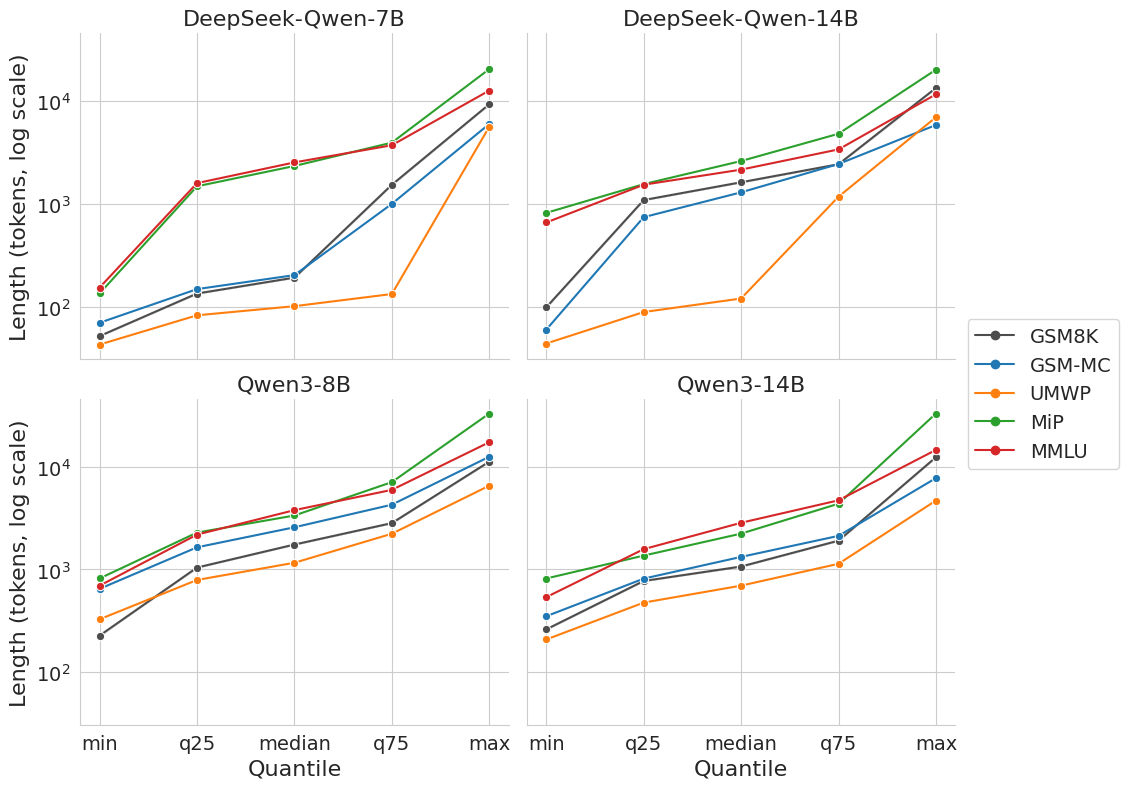

In [5]:
import ast

length_quantiles = stopping_rule_results_summary[stopping_rule_results_summary['stopping_rule'] == 'Length'][['model_name', 'dataset', 'cal_length_quartiles', 'test_length_quartiles']]
# parse stored strings safely and keep only well-posed test quantiles
length_quantiles['cal_length_quartiles'] = length_quantiles['cal_length_quartiles'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
length_quantiles['test_length_quartiles'] = length_quantiles['test_length_quartiles'].apply(lambda x: ast.literal_eval(x)[1] if isinstance(x, str) else x[1])

# keep only for 4 models: deepseek-ai/DeepSeek-R1-Distill-Qwen-7B, deepseek-ai/DeepSeek-R1-Distill-Qwen-14B, Qwen/Qwen3-8B, Qwen/Qwen3-14B
length_quantiles = length_quantiles[length_quantiles['model_name'].isin([
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
    'Qwen/Qwen3-8B',
    'Qwen/Qwen3-14B'
])]

# Plot calibration vs test length quantiles (well-posed) per model/dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

quantile_order = ['min', 'q25', 'median', 'q75', 'max']

dataset_labels = {
    'mc': 'GSM-MC',
    'umwp': 'UMWP',
    'mip': 'MiP',
    'mmlu': 'MMLU',
}

MODELS_SHORT_NAME = {
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': 'DeepSeek-Qwen-7B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B': 'DeepSeek-Qwen-14B',
    'Qwen/Qwen3-8B': 'Qwen3-8B',
    'Qwen/Qwen3-14B': 'Qwen3-14B'
}

records = []
for _, row in length_quantiles.iterrows():
    cal_vals = row['cal_length_quartiles']
    test_vals = row['test_length_quartiles']
    for label, cal_v, test_v in zip(quantile_order, cal_vals, test_vals):
        records.append({
            'model_name': row['model_name'],
            'dataset': row['dataset'],
            'quantile': label,
            'split': 'GSM8K',
            'value': cal_v
        })
        records.append({
            'model_name': row['model_name'],
            'dataset': row['dataset'],
            'quantile': label,
            'split': f"{dataset_labels.get(row['dataset'], row['dataset'])}",
            'value': test_v
        })

plot_df = pd.DataFrame(records)
plot_df['model_short'] = plot_df['model_name'].map(MODELS_SHORT_NAME)
plot_df['dataset_pretty'] = plot_df['dataset'].map(dataset_labels).fillna(plot_df['dataset'])

# Desired legend order: calibration first, then datasets in dataset_labels order (not alphabetical)
ordered_test_splits = [dataset_labels[k] for k in dataset_labels.keys()]  # preserves dict insertion order (py3.7+)
unique_splits = ['GSM8K'] + ordered_test_splits

# Palette: GSM8K in neutral gray, datasets in distinct hues
palette = {'GSM8K': '#4d4d4d'}
palette.update({
    s: c for s, c in zip(
        unique_splits[1:],
        sns.color_palette('tab10', n_colors=len(unique_splits) - 1)
    )
})

sns.set_style('whitegrid')
g = sns.relplot(
    data=plot_df,
    x='quantile',
    y='value',
    hue='split',
    palette=palette,
    hue_order=unique_splits,   # controls color mapping / plotting order
    col='model_short',
    col_wrap=2,
    kind='line',
    marker='o',
    height=4,
    aspect=1.2
)

# Log scale to handle long tails
g.set(yscale='log')
g.set_titles('{col_name}')
g.set_axis_labels('Quantile', 'Length (tokens, log scale)')

# Remove internal facet legend (if present)
if getattr(g, '_legend', None):
    try:
        g._legend.remove()
    except Exception:
        pass

# --- Build a single global legend that respects unique_splits order ---
ax0 = g.axes.flatten()[0]
handles, labels = ax0.get_legend_handles_labels()

# Map label -> handle (keeps one handle per label)
label_to_handle = {}
for h, l in zip(handles, labels):
    if l not in label_to_handle:
        label_to_handle[l] = h

# Reorder exactly according to unique_splits
ordered_handles = [label_to_handle[l] for l in unique_splits if l in label_to_handle]
ordered_labels  = [l for l in unique_splits if l in label_to_handle]

# Optional: sanity check (comment out if you prefer)
missing = set(unique_splits) - set(label_to_handle.keys())
if missing:
    print("Warning: missing legend labels:", missing)

# Place global legend outside the plot on the right
g.fig.legend(
    ordered_handles,
    ordered_labels,
    loc='center right',
    bbox_to_anchor=(1.02, 0.5),
)

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.88, 1])
# savefig 
plt.savefig('figs/shift.png', dpi=300, bbox_inches='tight')
plt.show()


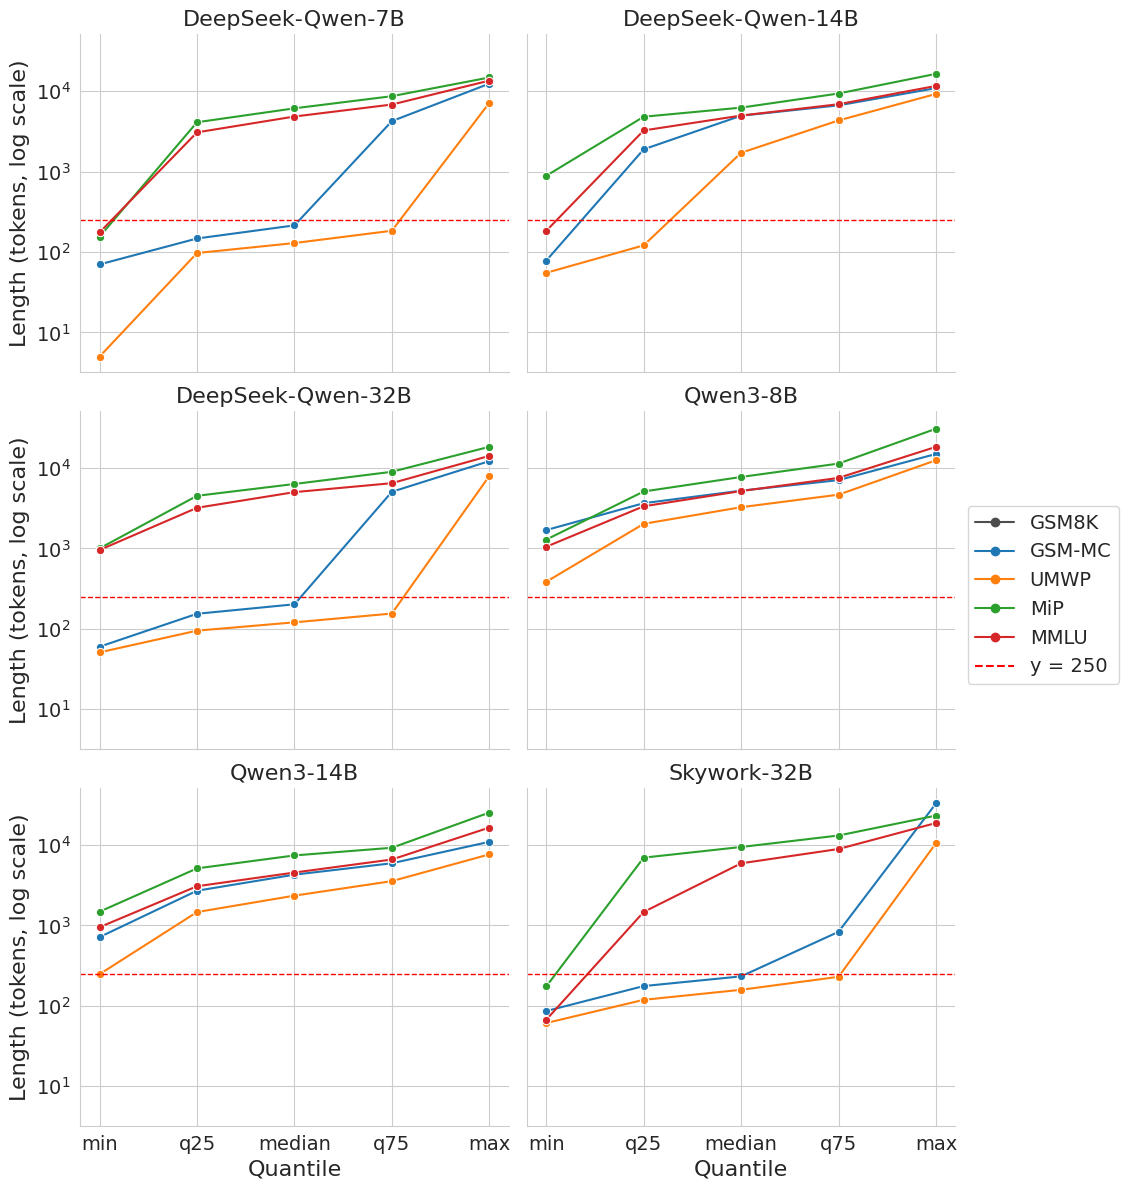

In [6]:
# Plot calibration vs test length quantiles (well-posed) per model/dataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import ast

length_quantiles = stopping_rule_results_summary[stopping_rule_results_summary['stopping_rule'] == 'Length'][['model_name', 'dataset', 'cal_length_quartiles', 'test_length_quartiles']]
# parse stored strings safely and keep only well-posed test quantiles
length_quantiles['test_length_quartiles'] = length_quantiles['test_length_quartiles'].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) else x[0])

# keep only for 4 models: deepseek-ai/DeepSeek-R1-Distill-Qwen-7B, deepseek-ai/DeepSeek-R1-Distill-Qwen-14B, Qwen/Qwen3-8B, Qwen/Qwen3-14B
length_quantiles = length_quantiles[length_quantiles['model_name'].isin([
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B',
    'Skywork/Skywork-OR1-32B',
    'Qwen/Qwen3-8B',
    'Qwen/Qwen3-14B',
])]


quantile_order = ['min', 'q25', 'median', 'q75', 'max']

dataset_labels = {
    'mc': 'GSM-MC',
    'umwp': 'UMWP',
    'mip': 'MiP',
    'mmlu': 'MMLU',
}

MODELS_SHORT_NAME = {
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': 'DeepSeek-Qwen-7B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B': 'DeepSeek-Qwen-14B',
    'deepseek-ai/DeepSeek-R1-Distill-Qwen-32B': 'DeepSeek-Qwen-32B',
    'Skywork/Skywork-OR1-32B': 'Skywork-32B',
    'Qwen/Qwen3-8B': 'Qwen3-8B',
    'Qwen/Qwen3-14B': 'Qwen3-14B',
}

records = []
for _, row in length_quantiles.iterrows():
    test_vals = row['test_length_quartiles']
    for label, test_v in zip(quantile_order, test_vals):
        records.append({
            'model_name': row['model_name'],
            'dataset': row['dataset'],
            'quantile': label,
            'split': f"{dataset_labels.get(row['dataset'], row['dataset'])}",
            'value': test_v
        })

plot_df = pd.DataFrame(records)
plot_df['model_short'] = plot_df['model_name'].map(MODELS_SHORT_NAME)
plot_df['dataset_pretty'] = plot_df['dataset'].map(dataset_labels).fillna(plot_df['dataset'])

# Desired legend order: calibration first, then datasets in dataset_labels order (not alphabetical)
ordered_test_splits = [dataset_labels[k] for k in dataset_labels.keys()]  # preserves dict insertion order (py3.7+)
unique_splits = ['GSM8K'] + ordered_test_splits

# Palette: GSM8K in neutral gray, datasets in distinct hues
palette = {'GSM8K': '#4d4d4d'}
palette.update({
    s: c for s, c in zip(
        unique_splits[1:],
        sns.color_palette('tab10', n_colors=len(unique_splits) - 1)
    )
})

sns.set_style('whitegrid')
g = sns.relplot(
    data=plot_df,
    x='quantile',
    y='value',
    hue='split',
    palette=palette,
    hue_order=unique_splits,   # controls color mapping / plotting order
    col='model_short',
    col_wrap=2,
    kind='line',
    marker='o',
    height=4,
    aspect=1.2
)

# Log scale to handle long tails
g.set(yscale='log')
g.set_titles('{col_name}')
g.set_axis_labels('Quantile', 'Length (tokens, log scale)')

# Remove internal facet legend (if present)
if getattr(g, '_legend', None):
    try:
        g._legend.remove()
    except Exception:
        pass

# draw a horizontal line at y=250
for ax in g.axes.flatten():
    ax.axhline(y=250, color='red', linestyle='--', linewidth=1)

# --- Build a single global legend that respects unique_splits order ---
ax0 = g.axes.flatten()[0]
handles, labels = ax0.get_legend_handles_labels()

# Map label -> handle (keeps one handle per label)
label_to_handle = {}
for h, l in zip(handles, labels):
    if l not in label_to_handle:
        label_to_handle[l] = h

# Reorder exactly according to unique_splits
ordered_handles = [label_to_handle[l] for l in unique_splits if l in label_to_handle]
ordered_labels  = [l for l in unique_splits if l in label_to_handle]
# add the legend for the horizontal line
import matplotlib.lines as mlines
line_250 = mlines.Line2D([], [], color='red', linestyle='--', label='y = 250')
ordered_handles.append(line_250)
ordered_labels.append('y = 250')

# Optional: sanity check (comment out if you prefer)
missing = set(unique_splits) - set(label_to_handle.keys())
if missing:
    print("Warning: missing legend labels:", missing)

# Place global legend outside the plot on the right
g.fig.legend(
    ordered_handles,
    ordered_labels,
    loc='center right',
    bbox_to_anchor=(1.02, 0.5),
)

# Adjust layout to make room for legend
plt.tight_layout(rect=[0, 0, 0.88, 1])
# savefig 
plt.savefig('figs/short.png', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
# create a table that compares the fpr and power of all methods 
# notice that for stopping_rule_results_summary, there are 3 kinds of stopping rules -- so grouping is needed on the stopping_rule column

# create one comparison table per dataset
datasets = ['mc', 'umwp', 'mip', 'mmlu']

comparison_tables = {}
methods_sr = ['Length', 'Renewal', 'Maxwise']


for ds in datasets:
    rows = []
    rows.append({
        'method': 'No Intervention',
        'fpr': results_summary.loc[results_summary['dataset'] == ds, 'fpr'].mean() * 100,
        'power': results_summary.loc[results_summary['dataset'] == ds, 'power'].mean() * 100
    })
    rows.append({
        'method': 'Confidence',
        'fpr': results_prompt_intervention_summary.loc[results_prompt_intervention_summary['dataset'] == ds, 'fpr'].mean() * 100,
        'power': results_prompt_intervention_summary.loc[results_prompt_intervention_summary['dataset'] == ds, 'power'].mean() * 100
    })
    rows.append({
        'method': 'Criticism',
        'fpr': results_prompt_intervention_criticism_summary.loc[results_prompt_intervention_criticism_summary['dataset'] == ds, 'fpr'].mean() * 100,
        'power': results_prompt_intervention_criticism_summary.loc[results_prompt_intervention_criticism_summary['dataset'] == ds, 'power'].mean() * 100
    })

    for sr in methods_sr:
        df_sr = stopping_rule_results_summary.loc[
            (stopping_rule_results_summary['dataset'] == ds) &
            (stopping_rule_results_summary['stopping_rule'] == sr)
        ]
        rows.append({
            'method': sr,
            'fpr': df_sr['fpr'].mean(),
            'power': df_sr['power'].mean()
        })

    comparison_tables[ds] = pd.DataFrame(rows)

In [8]:
# Order and pretty labels exactly like your screenshot
method_order = [
    "No Intervention",
    "Confidence",
    "Criticism",
    "Length",
    "Renewal",
    "Maxwise",
]

dataset_order = ['mc', 'umwp', 'mip', 'mmlu']

# 1. Combine all datasets into a wide MultiIndex table
wide = pd.concat(
    {ds: comparison_tables[ds].set_index("method") for ds in dataset_order},
    axis=1
)

# reorder rows
wide = wide.reindex(method_order)

def fmt(x):
    if pd.isna(x):
        return ""
    return f"{x:.2f}\\%"

wide = wide.applymap(fmt)

metric_labels = {"fpr": "FPR", "power": "Power", "soft_upperbound": "Soft UB"}

wide.columns = pd.MultiIndex.from_tuples(
    [(dataset_labels[ds], metric_labels[metric]) for ds, metric in wide.columns]
)

wide.index.name = None

latex = wide.to_latex(
    escape=False,
    multicolumn=True,
    multicolumn_format="c",
    column_format="l" + "cc"*len(dataset_order),
    bold_rows=False,
)

# Now replace the empty top-left corner with "Stopping Rule"
latex = latex.replace(
    "{} & FPR",  # beginning of second header row
    "Stopping Rule & FPR"
)

# change the first cell after \toprule to multirow{2}{*}{Stopping Rule}
latex = latex.replace(
    " & \multicolumn{2}{c}{GSM-MC}",
    " \\multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GSM-MC}"
)


print("========================================")
print(" LaTeX TABLE OUTPUT")
print("========================================")
print(latex)


 LaTeX TABLE OUTPUT
\begin{tabular}{lcccccccc}
\toprule
 \multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GSM-MC} & \multicolumn{2}{c}{UMWP} & \multicolumn{2}{c}{MiP} & \multicolumn{2}{c}{MMLU} \\
 & FPR & Power & FPR & Power & FPR & Power & FPR & Power \\
\midrule
No Intervention & 0.00\% & 6.75\% & 0.00\% & 8.95\% & 0.00\% & 1.12\% & 0.00\% & 0.50\% \\
Confidence & 0.42\% & 5.42\% & -0.26\% & 10.05\% & -0.48\% & 0.48\% & 4.95\% & 12.16\% \\
Criticism & 0.67\% & 5.67\% & 0.26\% & 9.61\% & 0.32\% & 0.96\% & -0.50\% & 15.48\% \\
Length & 4.50\% & 32.17\% & 0.62\% & 8.59\% & 20.67\% & 61.54\% & 12.91\% & 39.85\% \\
Renewal & 3.75\% & 69.75\% & 2.92\% & 46.78\% & 1.12\% & 71.15\% & 0.75\% & 66.42\% \\
Maxwise & 5.42\% & 70.92\% & 5.52\% & 48.65\% & 3.21\% & 73.40\% & 2.63\% & 75.31\% \\
\bottomrule
\end{tabular}



<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:54: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_617908/2683163640.py:53: SyntaxWarning: invalid escape sequence '\m'
  " & \multicolumn{2}{c}{GSM-MC}",
/tmp/ipykernel_617908/2683163640.py:54: SyntaxWarning: invalid escape sequence '\m'
  " \\multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GSM-MC}"
/tmp/ipykernel_617908/2683163640.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide = wide.applymap(fmt)


In [9]:
from config import MODELS_SHORT_NAME

# metric can be "power" or "fpr"
def make_compact_tables(stopping_rule_results_summary, methods_sr,
                        metrics=("power", "fpr", "soft_upperbound")):
    compact_tables = {}

    for metric in metrics:
        for sr in methods_sr:
            df_sr = stopping_rule_results_summary[
                stopping_rule_results_summary["stopping_rule"] == sr
            ]

            # rows: model_name, columns: dataset, values: mean(metric)
            table = (
                df_sr.groupby(["model_name", "dataset"])[metric]
                    .mean()
                    .unstack("dataset")           # dataset names become columns
                    .reset_index()                # keep model_name as a column
                    .sort_values("model_name")
            )

            table.iloc[:, 1:] = (table.iloc[:, 1:]).round(2)

            compact_tables[f"{metric}_{sr}"] = table
            # replace model name with short names
            compact_tables[f"{metric}_{sr}"]['model_name'] = compact_tables[f"{metric}_{sr}"]['model_name'].map(MODELS_SHORT_NAME)

    return compact_tables

compact_tables = make_compact_tables(stopping_rule_results_summary, methods_sr)


def make_fpr_power_table(sr, compact_tables):
    """
    sr: stopping rule name, e.g. 'No Intervention'
    compact_tables: output of make_compact_tables(...)
                    must contain 'fpr_<sr>' and 'power_<sr>'
    returns: (latex_string, wide_dataframe)
    """
    # --- 1. get the compact tables for this stopping rule ---
    df_power = compact_tables[f"power_{sr}"].set_index("model_name")
    df_fpr   = compact_tables[f"fpr_{sr}"].set_index("model_name")
    df_soft_upperbound = compact_tables[f'soft_upperbound_{sr}'].set_index("model_name")

    # ensure dataset column order
    df_power = df_power[dataset_order]
    df_fpr   = df_fpr[dataset_order]
    df_soft_upperbound = df_soft_upperbound[dataset_order]

    # --- 2. combine into a wide table with MultiIndex columns (dataset, metric) ---
    combined = pd.concat(
        {
            ds: pd.DataFrame({
                "fpr": df_fpr[ds],
                "power": df_power[ds],
                "soft_upperbound": df_soft_upperbound[ds],
            })
            for ds in dataset_order
        },
        axis=1
    )

    # combined.columns is like: MultiIndex([(ds, 'fpr'), (ds, 'power'), ...])

    # pretty labels on columns
    col_tuples = [
        (dataset_labels[ds], metric_labels[metric])
        for ds, metric in combined.columns
    ]
    combined.columns = pd.MultiIndex.from_tuples(col_tuples)

    # --- 3. format numbers and add the model name as the first column ---
    formatted = combined.applymap(fmt)

    # put model_name back as a first column
    formatted.insert(0, ('', 'Model'), formatted.index)

    # reset index so we don't print row numbers
    formatted = formatted.reset_index(drop=True)

    # set final MultiIndex columns (first column has top-level '' and 'Model' second-level)
    formatted.columns = pd.MultiIndex.from_tuples(
        [('', 'Model')] + col_tuples
    )

    # add an average at the end
    # combined is still numeric with columns = col_tuples
    avg_numeric = combined.mean(axis=0)          # mean over models for each (dataset, metric)
    avg_formatted = avg_numeric.apply(fmt)

    # build a dict for the new row
    avg_row = {('', 'Model'): 'Average'}
    for col in col_tuples:
        avg_row[col] = avg_formatted[col]

    # append the Average row
    formatted = pd.concat([formatted, pd.DataFrame([avg_row])], ignore_index=True)

    # --- 4. LaTeX export ---
    latex = formatted.to_latex(
        index=False,
        escape=False,
        multicolumn=True,
        multicolumn_format="c",
        column_format="l" + "ccc"*len(dataset_order),  # Model + 3 per dataset
        bold_rows=False,
    )

    return latex, formatted

sr = "Renewal"
latex_str, wide_df = make_fpr_power_table(sr, compact_tables)
print(latex_str)

\begin{tabular}{lcccccccccccc}
\toprule
 & \multicolumn{3}{c}{GSM-MC} & \multicolumn{3}{c}{UMWP} & \multicolumn{3}{c}{MiP} & \multicolumn{3}{c}{MMLU} \\
Model & FPR & Power & Soft UB & FPR & Power & Soft UB & FPR & Power & Soft UB & FPR & Power & Soft UB \\
\midrule
DeepSeek-7B & 0.00\% & 28.00\% & 40.00\% & 0.88\% & 14.91\% & 21.49\% & 0.00\% & 55.77\% & 67.31\% & 0.75\% & 42.86\% & 82.67\% \\
DeepSeek-14B & 5.00\% & 70.00\% & 76.00\% & 2.19\% & 39.91\% & 51.32\% & 1.92\% & 73.08\% & 80.77\% & 0.75\% & 72.93\% & 88.00\% \\
DeepSeek-32B & 2.00\% & 30.00\% & 54.00\% & 0.00\% & 3.07\% & 45.61\% & 0.00\% & 73.08\% & 82.69\% & 0.75\% & 75.94\% & 86.45\% \\
QwQ-32B & 2.00\% & 82.00\% & 92.00\% & 2.19\% & 57.46\% & 71.93\% & 0.00\% & 67.31\% & 82.69\% & 0.75\% & 57.89\% & 87.98\% \\
Qwen3-8B & 6.00\% & 92.00\% & 97.00\% & 3.51\% & 71.93\% & 80.70\% & 0.00\% & 84.62\% & 88.46\% & 0.75\% & 80.45\% & 92.46\% \\
Qwen3-14B & 4.00\% & 88.00\% & 92.00\% & 2.63\% & 66.67\% & 78.51\% & 3.85\% & 80.77

/tmp/ipykernel_617908/4241001621.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sr.groupby(["model_name", "dataset"])[metric]
/tmp/ipykernel_617908/4241001621.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sr.groupby(["model_name", "dataset"])[metric]
/tmp/ipykernel_617908/4241001621.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_sr.groupby(["model_name", "dataset"])[metric]
/tmp/ipykernel_6179

In [10]:
sr = "Maxwise"
latex_str, wide_df = make_fpr_power_table(sr, compact_tables)
print(latex_str)

\begin{tabular}{lcccccccccccc}
\toprule
 & \multicolumn{3}{c}{GSM-MC} & \multicolumn{3}{c}{UMWP} & \multicolumn{3}{c}{MiP} & \multicolumn{3}{c}{MMLU} \\
Model & FPR & Power & Soft UB & FPR & Power & Soft UB & FPR & Power & Soft UB & FPR & Power & Soft UB \\
\midrule
DeepSeek-7B & 6.00\% & 50.00\% & 40.00\% & 5.26\% & 30.26\% & 22.37\% & 3.85\% & 78.85\% & 67.31\% & 5.26\% & 82.71\% & 82.67\% \\
DeepSeek-14B & 9.00\% & 72.00\% & 80.00\% & 2.63\% & 43.42\% & 51.32\% & 3.85\% & 78.85\% & 80.77\% & 3.01\% & 75.94\% & 88.00\% \\
DeepSeek-32B & 3.00\% & 33.00\% & 54.00\% & 0.00\% & 4.39\% & 45.61\% & 3.85\% & 82.69\% & 82.69\% & 4.51\% & 82.71\% & 86.45\% \\
QwQ-32B & 6.00\% & 81.00\% & 94.00\% & 6.14\% & 60.96\% & 75.88\% & 0.00\% & 63.46\% & 82.69\% & 1.50\% & 72.18\% & 87.98\% \\
Qwen3-8B & 5.00\% & 86.00\% & 91.00\% & 3.51\% & 66.67\% & 80.70\% & 3.85\% & 73.08\% & 88.46\% & 0.75\% & 81.95\% & 92.46\% \\
Qwen3-14B & 4.00\% & 88.00\% & 92.00\% & 6.58\% & 68.86\% & 81.58\% & 5.77\% & 82.69

/tmp/ipykernel_617908/4241001621.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  formatted = combined.applymap(fmt)


In [11]:
# create a table that compares the fpr and power of all methods 
# notice that for stopping_rule_results_summary, there are 3 kinds of stopping rules -- so grouping is needed on the stopping_rule column

comparison_tables = {}
methods_sr = ['Renewal', 'Maxwise']


for ds in datasets:
    rows = []
    for sr in methods_sr:
        df_sr = stopping_rule_results_summary.loc[
            (stopping_rule_results_summary['dataset'] == ds) &
            (stopping_rule_results_summary['stopping_rule'] == sr)
        ]
        rows.append({
            'method': sr,
            'token_saved': df_sr['avg_percentage_saved_ill_posed'].mean(),
        })

    comparison_tables[ds] = pd.DataFrame(rows)

wide = pd.DataFrame({
    ds: comparison_tables[ds].set_index('method')['token_saved']
    for ds in dataset_order
})

wide = wide.reindex(methods_sr)


wide = wide.applymap(fmt)


wide.columns = [dataset_labels[ds] for ds in wide.columns]

latex = wide.to_latex(
    escape=False,
    index=True,          # we want the stopping rule as the first column
    index_names=False,   # do not add a separate row for the index name
    column_format="l" + "c"*len(wide.columns),  # lcccc
    bold_rows=False,
)

latex = latex.replace(
    " & GSM-MC",  # beginning of second header row
    "Stopping Rule & GSM-MC"
)

print("========================================")
print(" LaTeX TABLE OUTPUT")
print("========================================")
print(latex)

 LaTeX TABLE OUTPUT
\begin{tabular}{lcccc}
\toprule
Stopping Rule & GSM-MC & UMWP & MiP & MMLU \\
\midrule
Renewal & 60.69\% & 38.29\% & 62.78\% & 58.80\% \\
Maxwise & 63.30\% & 41.10\% & 68.15\% & 69.83\% \\
\bottomrule
\end{tabular}



/tmp/ipykernel_617908/1963674523.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide = wide.applymap(fmt)


=== Stopping Rule: Renewal ===
Coefficient (slope): 0.8238
=== Stopping Rule: Maxwise ===
Coefficient (slope): 0.8532


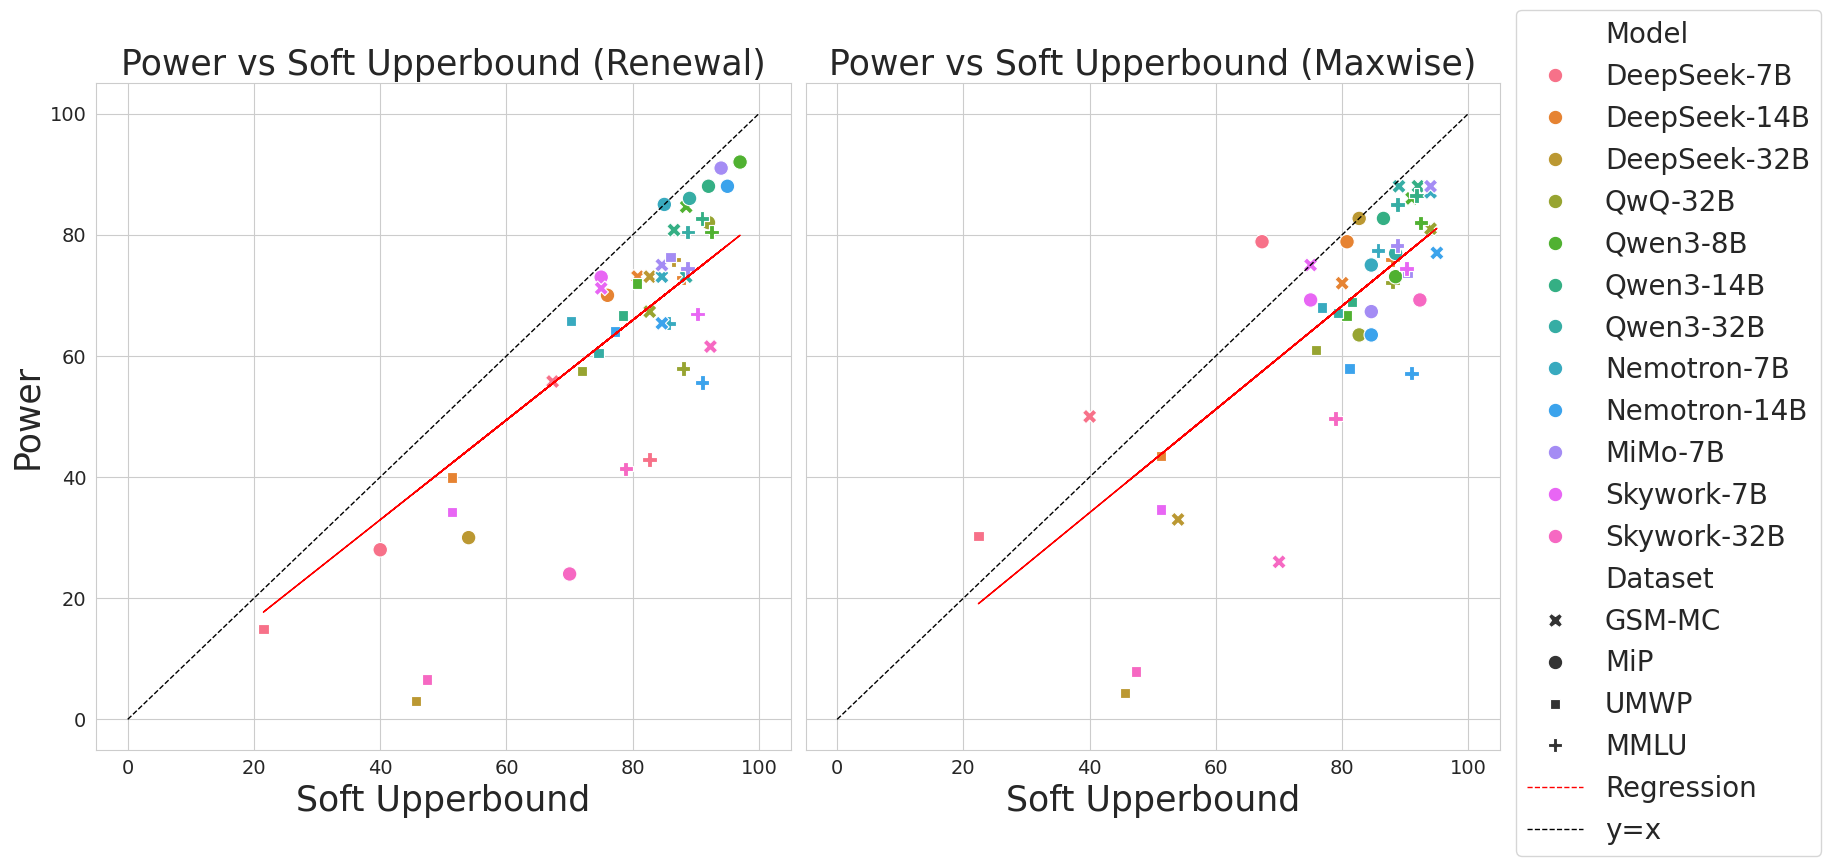

In [12]:
from config import MODELS_SHORT_NAME
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset rename map (same as what you used earlier)
DATASET_ALIASES = {
    "mc": "GSM-MC",
    "mip": "MiP",
    "mmlu": "MMLU",
    "umwp": "UMWP",
    'gpqa': 'GPQA',
}

# Only plot Renewal + Maxwise
target_srs = [
    "Renewal",
    "Maxwise",
]

fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

all_handles = []
all_labels = []

for ax, sr in zip(axes, target_srs):

    df_sr = stopping_rule_results_summary[
        stopping_rule_results_summary["stopping_rule"] == sr
    ][["model_name", "dataset", "power", "soft_upperbound"]]
    
    df_sr["model_name"] = df_sr["model_name"].map(MODELS_SHORT_NAME)
    df_sr["dataset"] = df_sr["dataset"].map(DATASET_ALIASES)
    # rename model_name and dataset for better visualization
    df_sr = df_sr.rename(columns={"model_name": "Model", "dataset": "Dataset"})

    # Scatterplot
    sns.scatterplot(
        data=df_sr,
        x="soft_upperbound",
        y="power",
        hue="Model",
        style="Dataset",
        s=110,
        ax=ax,
        legend=True     # we remove it right after collecting handles
    )

    # Remove subplot legend (so only a single main legend remains)
    if ax.legend_:
        ax.legend_.remove()

    # Diagonal y=x
    ax.plot([0, 100], [0, 100], "k--", linewidth=1)
    
    # fit a linear regression line through the origin
    from sklearn.linear_model import LinearRegression
    X = df_sr["soft_upperbound"].values.reshape(-1, 1)  

    y = df_sr["power"].values
    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    y_pred = model.predict(X)
    ax.plot(X, y_pred, color="r", linestyle="-", linewidth=1, label="Regression")
    print(f"=== Stopping Rule: {sr} ===")
    print(f"Coefficient (slope): {model.coef_[0]:.4f}")

    ax.set_title(f"Power vs Soft Upperbound ({sr})")
    ax.set_xlabel("Soft Upperbound")
    ax.set_ylabel("Power")
    # increase font size for better readability
    
    ax.title.set_fontsize(25)
    ax.xaxis.label.set_fontsize(25)
    ax.yaxis.label.set_fontsize(25)

    # Collect legend entries
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

# Deduplicate legend entries
unique = dict(zip(all_labels, all_handles))

# add the y=x line to the legend
unique["y=x"] = plt.Line2D([0], [0], color="k", linestyle="--", linewidth=1)
# add best fit line to the legend
unique["Regression"] = plt.Line2D([0], [0], color="r", linestyle="--", linewidth=1)



# Global legend on the right
fig.legend(
    unique.values(),
    unique.keys(),
    loc="center right",
    bbox_to_anchor=(1.15, 0.5),
    fontsize=20
)

plt.tight_layout(rect=[0, 0, 0.95, 1])  # add right margin for legend
plt.savefig("figs/power_vs_upperbound_math.png", dpi=300)
plt.show()

# Alternative Uncertainty Measures

In [13]:
# read the json data from `probe/`
# create a dataframe with columns: model, dataset
import pandas as pd
import ast

models = MODELS_LIST

df = []

for model in models:
    for data in datasets:
        with open(f'logits/{model}/{data}_stopping_results.jsonl', 'r') as f:
            lines = f.readlines()
            for line in lines:
                record = ast.literal_eval(line)
                df.append({
                    'model_name': model,
                    'dataset': data,
                    'stopping_rule': record['stopping_rule'],
                    "fpr": record['early_stopping_rate_well_posed'],
                    'power': record['early_stopping_rate_ill_posed']
                })

logits_df = pd.DataFrame(df)

In [14]:
stopping_rule_results_summary = pd.read_csv(base_path + "stopping_rule_results_summary.csv")

# sort the models according to MODELS_LIST
def sort_df_by_model_list(df, model_list):
    df['model_name'] = pd.Categorical(df['model_name'], categories=model_list, ordered=True)
    df = df.sort_values('model_name')
    return df
stopping_rule_results_summary = sort_df_by_model_list(stopping_rule_results_summary, MODELS_LIST)
# only keep if 
# 1/ is the length rule, or
# 2/ the lazy interval is 250, and the ablation is "none"; we save this for ablation comparison
stopping_rule_results_summary = stopping_rule_results_summary[
    (stopping_rule_results_summary['stopping_rule'] == 'Length') |
    ((stopping_rule_results_summary['lazy_interval'] == "250") & (stopping_rule_results_summary['ablation'] == 'none'))
]
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={"early_stopping_rate_well_posed": "fpr"})
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={"early_stopping_rate_ill_posed": "power"})

comparison_tables = {}
methods_sr = ['Maxwise']

deer_df = logits_df[logits_df['stopping_rule'] == 'DEERBasedStoppingRule']
entropy_df = logits_df[logits_df['stopping_rule'] == 'EntropyBasedStoppingRule']

for ds in datasets:
    rows = []
    rows.append({
        'method': 'DEER',
        'fpr': deer_df.loc[deer_df['dataset'] == ds, 'fpr'].mean(),
        'power': deer_df.loc[deer_df['dataset'] == ds, 'power'].mean()
    })
    rows.append({
        'method': 'Entropy',
        'fpr': entropy_df.loc[entropy_df['dataset'] == ds, 'fpr'].mean(),
        'power': entropy_df.loc[entropy_df['dataset'] == ds, 'power'].mean()
    })

    for sr in methods_sr:
        df_sr = stopping_rule_results_summary.loc[
            (stopping_rule_results_summary['dataset'] == ds) &
            (stopping_rule_results_summary['stopping_rule'] == sr)
        ]
        rows.append({
            'method': sr,
            'fpr': df_sr['fpr'].mean(),
            'power': df_sr['power'].mean()
        })

    comparison_tables[ds] = pd.DataFrame(rows)

# Order and pretty labels exactly like your screenshot
method_order = [
    "DEER",
    "Entropy",
    "Maxwise"
]

# 1. Combine all datasets into a wide MultiIndex table
wide = pd.concat(
    {ds: comparison_tables[ds].set_index("method") for ds in dataset_order},
    axis=1
)

# reorder rows
wide = wide.reindex(method_order)

# 2. Format numbers as percentages like the LaTeX figure
def fmt(x):
    if pd.isna(x):
        return ""
    return f"{x:.2f}\\%"

wide = wide.applymap(fmt)

wide.columns = pd.MultiIndex.from_tuples(
    [(dataset_labels[ds], metric_labels[metric]) for ds, metric in wide.columns]
)

wide.index.name = None

latex = wide.to_latex(
    escape=False,
    multicolumn=True,
    multicolumn_format="c",
    column_format="l" + "cc"*len(dataset_order),
    bold_rows=False,
)

# Now replace the empty top-left corner with "Stopping Rule"
latex = latex.replace(
    "{} & FPR",  # beginning of second header row
    "Stopping Rule & FPR"
)

# change the first cell after \toprule to multirow{2}{*}{Stopping Rule}
latex = latex.replace(
    " & \multicolumn{2}{c}{GSM-MC}",
    " \\multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GSM-MC}"
)


print("========================================")
print(" LaTeX TABLE OUTPUT")
print("========================================")
print(latex)


 LaTeX TABLE OUTPUT
\begin{tabular}{lcccccccc}
\toprule
 \multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GSM-MC} & \multicolumn{2}{c}{UMWP} & \multicolumn{2}{c}{MiP} & \multicolumn{2}{c}{MMLU} \\
 & FPR & Power & FPR & Power & FPR & Power & FPR & Power \\
\midrule
DEER & 5.08\% & 37.25\% & 2.12\% & 18.86\% & 16.67\% & 62.34\% & 20.18\% & 52.63\% \\
Entropy & 4.83\% & 44.92\% & 1.32\% & 15.31\% & 19.39\% & 55.45\% & 2.57\% & 15.29\% \\
Maxwise & 5.42\% & 70.92\% & 5.52\% & 48.65\% & 3.21\% & 73.40\% & 2.63\% & 75.31\% \\
\bottomrule
\end{tabular}



<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:98: SyntaxWarning: invalid escape sequence '\m'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:98: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_617908/1025421070.py:97: SyntaxWarning: invalid escape sequence '\m'
  " & \multicolumn{2}{c}{GSM-MC}",
/tmp/ipykernel_617908/1025421070.py:98: SyntaxWarning: invalid escape sequence '\m'
  " \\multirow{2}{*}{Stopping Rule} & \multicolumn{2}{c}{GSM-MC}"
/tmp/ipykernel_617908/1025421070.py:73: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide = wide.applymap(fmt)


# Comparison Against Probe Based Methods

In [15]:
import json
import os

# Define models and their corresponding probe directories
models_probe_info = [
    {
        'name': 'DeepSeek-R1-7B',
        'path': 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B',
        'layer_file': 'training_results_layer17.json'
    },
    {
        'name': 'DeepSeek-R1-14B',
        'path': 'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
        'layer_file': 'training_results_layer30.json'
    },
    {
        'name': 'Qwen3-8B',
        'path': 'Qwen/Qwen3-8B',
        'layer_file': 'training_results_layer24.json'
    },
    {
        'name': 'Qwen3-14B',
        'path': 'Qwen/Qwen3-14B',
        'layer_file': 'training_results_layer26.json'
    }
]

# Read probe statistics
probe_stats = []
for model_info in models_probe_info:
    json_path = f"probe/{model_info['path']}/{model_info['layer_file']}"
    
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Extract layer number from the data
    optimal_layer = data['layer_idx']
    
    probe_stats.append({
        'Model': model_info['name'],
        'Dataset Size': data['dataset_size'],
        'Feature Dim': data['feature_dim'],
        'Optimal Layer': optimal_layer,
        'ROC-AUC': data['roc_auc']
    })

# Create DataFrame
probe_df = pd.DataFrame(probe_stats)

# Generate LaTeX table
print(r"\begin{table}[h]")
print(r"\centering")
print(r"\small")
print(r"\begin{tabular}{lcccc}")
print(r"\toprule")
print(r"Model & Dataset Size & Feature Dim & Optimal Layer & ROC-AUC \\")
print(r"\midrule")

for _, row in probe_df.iterrows():
    print(f"{row['Model']} & {row['Dataset Size']:,} & {row['Feature Dim']:,} & {row['Optimal Layer']} & {row['ROC-AUC']:.4f} \\\\")

print(r"\bottomrule")
print(r"\end{tabular}")
print(r"\caption{Linear probe dataset characteristics and performance across models.}")
print(r"\label{tab:probe statistics}")
print(r"\end{table}")

# Display as DataFrame for reference
probe_df

\begin{table}[h]
\centering
\small
\begin{tabular}{lcccc}
\toprule
Model & Dataset Size & Feature Dim & Optimal Layer & ROC-AUC \\
\midrule
DeepSeek-R1-7B & 137,588 & 3,584 & 17 & 0.9887 \\
DeepSeek-R1-14B & 371,464 & 5,120 & 30 & 0.9981 \\
Qwen3-8B & 386,815 & 4,096 & 24 & 0.9995 \\
Qwen3-14B & 352,361 & 5,120 & 26 & 0.9995 \\
\bottomrule
\end{tabular}
\caption{Linear probe dataset characteristics and performance across models.}
\label{tab:probe statistics}
\end{table}


,Model,Dataset Size,Feature Dim,Optimal Layer,ROC-AUC
0,DeepSeek-R1-7B,137588,3584,17,0.988723
1,DeepSeek-R1-14B,371464,5120,30,0.998120
2,Qwen3-8B,386815,4096,24,0.999530
3,Qwen3-14B,352361,5120,26,0.999514


In [16]:
# read the json data from `probe/`
# create a dataframe with columns: model, dataset
import pandas as pd
import ast

models = ['Qwen/Qwen3-8B', 'Qwen/Qwen3-14B', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B']

df = []

for model in models:
    for data in datasets:
        with open(f'probe/{model}/{data}_probe_stopping_results.jsonl', 'r') as f:
            lines = f.readlines()
            for line in lines:
                record = ast.literal_eval(line)
                df.append({
                    'model_name': model,
                    'dataset': data,
                    'stopping_rule': 'Probe',
                    "fpr": record['early_stopping_rate_well_posed'],
                    'power': record['early_stopping_rate_ill_posed']
                })

probe_df = pd.DataFrame(df)

In [17]:
# concatenate the probe_df with stopping_rule_results_summary on the two models

df_subset = stopping_rule_results_summary[
    stopping_rule_results_summary['model_name'].isin(models)
][['model_name', 'dataset', 'stopping_rule', 'fpr', 'power']]

combined_df = pd.concat([df_subset, probe_df], ignore_index=True)

In [18]:
import pandas as pd

sub = combined_df[combined_df["dataset"].isin(dataset_order)].copy()

wide = (
    sub
    .set_index(["model_name", "stopping_rule", "dataset"])[["fpr", "power"]]
    .unstack("dataset")  # columns: ('fpr', ds), ('power', ds)
)

# Make columns be (dataset, metric) instead of (metric, dataset)
wide = wide.swaplevel(0, 1, axis=1).sort_index(axis=1)

# Reorder datasets in the desired order
wide = wide.reindex(dataset_order, axis=1, level=0)

# Relabel columns using pretty labels
wide.columns = pd.MultiIndex.from_tuples(
    [(dataset_labels[ds], metric_labels[metric]) for ds, metric in wide.columns]
)

# Only display 2 decimal places and add "\%"
wide = wide.applymap(lambda x: f"{x:.2f}\\%" if pd.notna(x) else "")

# ----------------------------------------------------------------------
# 3. Put index in a convenient form (no multirow logic anymore)
# ----------------------------------------------------------------------
wide = wide.sort_index()  # just to be deterministic
wide = wide.reset_index()  # columns: model_name, stopping_rule, (GSM-MC,FPR),...

# Optional: filter to specific models if needed
stop_order = ["Probe", "Renewal", "Maxwise"]

# For the compact display, define how to split the model name
# into the two lines you want for each model block.
model_display = {
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B": ("DeepSeek", "-R1-7B"),
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B": ("DeepSeek", "-R1-14B"),
    "Qwen/Qwen3-8B": ("Qwen3", "-8B"),
    "Qwen/Qwen3-14B": ("Qwen3", "-14B"),
}

# Convenience: ordered dataset labels in the same order as dataset_order
ds_labels_in_order = [dataset_labels[ds] for ds in dataset_order]

# ----------------------------------------------------------------------
# 4. Build LaTeX string manually
# ----------------------------------------------------------------------
cols_spec = "ll" + "cc" * len(dataset_order)
lines = []

# Begin + top rule
lines.append(r"\begin{tabular}{" + cols_spec + "}")
lines.append(r"\toprule")

# First header row
header1 = (
    r" \multirow{2}{*}{Model} & Stopping"
    + "".join([f" & \\multicolumn{2}{{c}}{{{lbl}}}" for lbl in ds_labels_in_order])
    + r" \\"
)
lines.append(header1)

# Second header row
header2 = (
    r" & Rule"
    + "".join([" & FPR & Power" for _ in ds_labels_in_order])
    + r" \\"
)
lines.append(header2)
lines.append(r"\midrule")

# Body rows, by model block
for mi, model in enumerate(model_display.keys()):
    prefix, suffix = model_display[model]

    # For each stopping rule, pick the row for this model+rule
    for si, rule in enumerate(stop_order):
        row = wide[(wide["model_name"] == model) & (wide["stopping_rule"] == rule)]
        if row.empty:
            continue
        row = row.iloc[0]

        # First column (Model) content per row
        if si == 0:
            model_cell = prefix
        elif si == 1:
            model_cell = suffix
        else:
            model_cell = ""

        # Second column: the stopping rule
        stop_cell = rule

        # Data cells: FPR, Power per dataset label
        data_cells = []
        for ds_lbl in ds_labels_in_order:
            fpr_val = row[(ds_lbl, "FPR")]
            power_val = row[(ds_lbl, "Power")]
            data_cells.extend([fpr_val, power_val])

        line = " & ".join([model_cell, stop_cell] + data_cells) + r" \\"
        lines.append(line)

    # Add \cline after each model block, except maybe last if you prefer
    lines.append(r"\cline{1-" + str(2 + 2 * len(dataset_order)) + "}")

# Bottom rule and end
lines.append(r"\bottomrule")
lines.append(r"\end{tabular}")

latex = "\n".join(lines)

print("========================================")
print(" LaTeX TABLE OUTPUT FOR QWEN MODELS")
print("========================================")
print(latex)

 LaTeX TABLE OUTPUT FOR QWEN MODELS
\begin{tabular}{llcccccccc}
\toprule
 \multirow{2}{*}{Model} & Stopping & \multicolumn2{c}{GSM-MC} & \multicolumn2{c}{UMWP} & \multicolumn2{c}{MiP} & \multicolumn2{c}{MMLU} \\
 & Rule & FPR & Power & FPR & Power & FPR & Power & FPR & Power \\
\midrule
DeepSeek & Probe & 6.00\% & 33.00\% & 4.82\% & 39.04\% & 38.46\% & 86.54\% & 35.34\% & 93.23\% \\
-R1-7B & Renewal & 0.00\% & 28.00\% & 0.88\% & 14.91\% & 0.00\% & 55.77\% & 0.75\% & 42.86\% \\
 & Maxwise & 6.00\% & 50.00\% & 5.26\% & 30.26\% & 3.85\% & 78.85\% & 5.26\% & 82.71\% \\
\cline{1-10}
DeepSeek & Probe & 3.00\% & 64.00\% & 4.39\% & 56.14\% & 30.77\% & 88.46\% & 30.83\% & 97.74\% \\
-R1-14B & Renewal & 5.00\% & 70.00\% & 2.19\% & 39.91\% & 1.92\% & 73.08\% & 0.75\% & 72.93\% \\
 & Maxwise & 9.00\% & 72.00\% & 2.63\% & 43.42\% & 3.85\% & 78.85\% & 3.01\% & 75.94\% \\
\cline{1-10}
Qwen3 & Probe & 7.00\% & 78.00\% & 3.95\% & 64.04\% & 34.62\% & 96.15\% & 43.61\% & 97.74\% \\
-8B & Renewal & 6.00\%

/tmp/ipykernel_617908/626518345.py:23: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide = wide.applymap(lambda x: f"{x:.2f}\\%" if pd.notna(x) else "")


In [19]:
models = ['Qwen/Qwen3-8B', 'Qwen/Qwen3-14B', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B', 'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B']

df = []

for model in models:
    for data in datasets:
        with open(f'probe/{model}/{data}_pls_stopping_results.jsonl', 'r') as f:
            lines = f.readlines()
            for line in lines:
                record = ast.literal_eval(line)
                df.append({
                    'model_name': model,
                    'dataset': data,
                    'stopping_rule': 'PLS',
                    "fpr": record['early_stopping_rate_well_posed'],
                    'power': record['early_stopping_rate_ill_posed']
                })

pls_df = pd.DataFrame(df)

df_subset = stopping_rule_results_summary[
    stopping_rule_results_summary['model_name'].isin(models)
][['model_name', 'dataset', 'stopping_rule', 'fpr', 'power']]

combined_df = pd.concat([pls_df, probe_df], ignore_index=True)

In [20]:
sub = combined_df[combined_df["dataset"].isin(dataset_order)].copy()

wide = (
    sub
    .set_index(["model_name", "stopping_rule", "dataset"])[["fpr", "power"]]
    .unstack("dataset")  # columns: ('fpr', ds), ('power', ds)
)

# Make columns be (dataset, metric) instead of (metric, dataset)
wide = wide.swaplevel(0, 1, axis=1).sort_index(axis=1)

# Reorder datasets in the desired order
wide = wide.reindex(dataset_order, axis=1, level=0)

# Relabel columns using pretty labels
wide.columns = pd.MultiIndex.from_tuples(
    [(dataset_labels[ds], metric_labels[metric]) for ds, metric in wide.columns]
)

# Only display 2 decimal places and add "\%"
wide = wide.applymap(lambda x: f"{x:.2f}\\%" if pd.notna(x) else "")

# ----------------------------------------------------------------------
# 3. Put index in a convenient form (no multirow logic anymore)
# ----------------------------------------------------------------------
wide = wide.sort_index()  # just to be deterministic
wide = wide.reset_index()  # columns: model_name, stopping_rule, (GSM-MC,FPR),...

# Optional: filter to specific models if needed
stop_order = ["Probe", "PLS"]

# Convenience: ordered dataset labels in the same order as dataset_order
ds_labels_in_order = [dataset_labels[ds] for ds in dataset_order]

# ----------------------------------------------------------------------
# 4. Build LaTeX string manually
# ----------------------------------------------------------------------
cols_spec = "ll" + "cc" * len(dataset_order)
lines = []

# Begin + top rule
lines.append(r"\begin{tabular}{" + cols_spec + "}")
lines.append(r"\toprule")

# First header row
header1 = (
    r" \multirow{2}{*}{Model} & Stopping"
    + "".join([f" & \\multicolumn{2}{{c}}{{{lbl}}}" for lbl in ds_labels_in_order])
    + r" \\"
)
lines.append(header1)

# Second header row
header2 = (
    r" & Rule"
    + "".join([" & FPR & Power" for _ in ds_labels_in_order])
    + r" \\"
)
lines.append(header2)
lines.append(r"\midrule")

# Body rows, by model block
for mi, model in enumerate(model_display.keys()):
    prefix, suffix = model_display[model]

    # For each stopping rule, pick the row for this model+rule
    for si, rule in enumerate(stop_order):
        row = wide[(wide["model_name"] == model) & (wide["stopping_rule"] == rule)]
        if row.empty:
            continue
        row = row.iloc[0]

        # First column (Model) content per row
        if si == 0:
            model_cell = prefix
        elif si == 1:
            model_cell = suffix
        else:
            model_cell = ""

        # Second column: the stopping rule
        stop_cell = rule

        # Data cells: FPR, Power per dataset label
        data_cells = []
        for ds_lbl in ds_labels_in_order:
            fpr_val = row[(ds_lbl, "FPR")]
            power_val = row[(ds_lbl, "Power")]
            data_cells.extend([fpr_val, power_val])

        line = " & ".join([model_cell, stop_cell] + data_cells) + r" \\"
        lines.append(line)

    # Add \cline after each model block, except maybe last if you prefer
    lines.append(r"\cline{1-" + str(2 + 2 * len(dataset_order)) + "}")

# Bottom rule and end
lines.append(r"\bottomrule")
lines.append(r"\end{tabular}")

latex = "\n".join(lines)

print("========================================")
print(" LaTeX TABLE OUTPUT FOR QWEN MODELS")
print("========================================")
print(latex)

 LaTeX TABLE OUTPUT FOR QWEN MODELS
\begin{tabular}{llcccccccc}
\toprule
 \multirow{2}{*}{Model} & Stopping & \multicolumn2{c}{GSM-MC} & \multicolumn2{c}{UMWP} & \multicolumn2{c}{MiP} & \multicolumn2{c}{MMLU} \\
 & Rule & FPR & Power & FPR & Power & FPR & Power & FPR & Power \\
\midrule
DeepSeek & Probe & 6.00\% & 33.00\% & 4.82\% & 39.04\% & 38.46\% & 86.54\% & 35.34\% & 93.23\% \\
-R1-7B & PLS & 3.00\% & 29.00\% & 0.44\% & 10.09\% & 7.69\% & 69.23\% & 6.77\% & 84.96\% \\
\cline{1-10}
DeepSeek & Probe & 3.00\% & 64.00\% & 4.39\% & 56.14\% & 30.77\% & 88.46\% & 30.83\% & 97.74\% \\
-R1-14B & PLS & 5.00\% & 68.00\% & 6.14\% & 51.75\% & 7.69\% & 84.62\% & 2.26\% & 87.22\% \\
\cline{1-10}
Qwen3 & Probe & 7.00\% & 78.00\% & 3.95\% & 64.04\% & 34.62\% & 96.15\% & 43.61\% & 97.74\% \\
-8B & PLS & 11.00\% & 97.00\% & 11.84\% & 85.96\% & 21.15\% & 98.08\% & 12.78\% & 93.23\% \\
\cline{1-10}
Qwen3 & Probe & 6.00\% & 88.00\% & 2.63\% & 67.98\% & 40.38\% & 94.23\% & 40.60\% & 95.49\% \\
-14B & PL

/tmp/ipykernel_617908/2279966925.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  wide = wide.applymap(lambda x: f"{x:.2f}\\%" if pd.notna(x) else "")


# Ablation Studies

First, we study the effect of changing the uncertainty keywords used in the soft upperbound calculation.

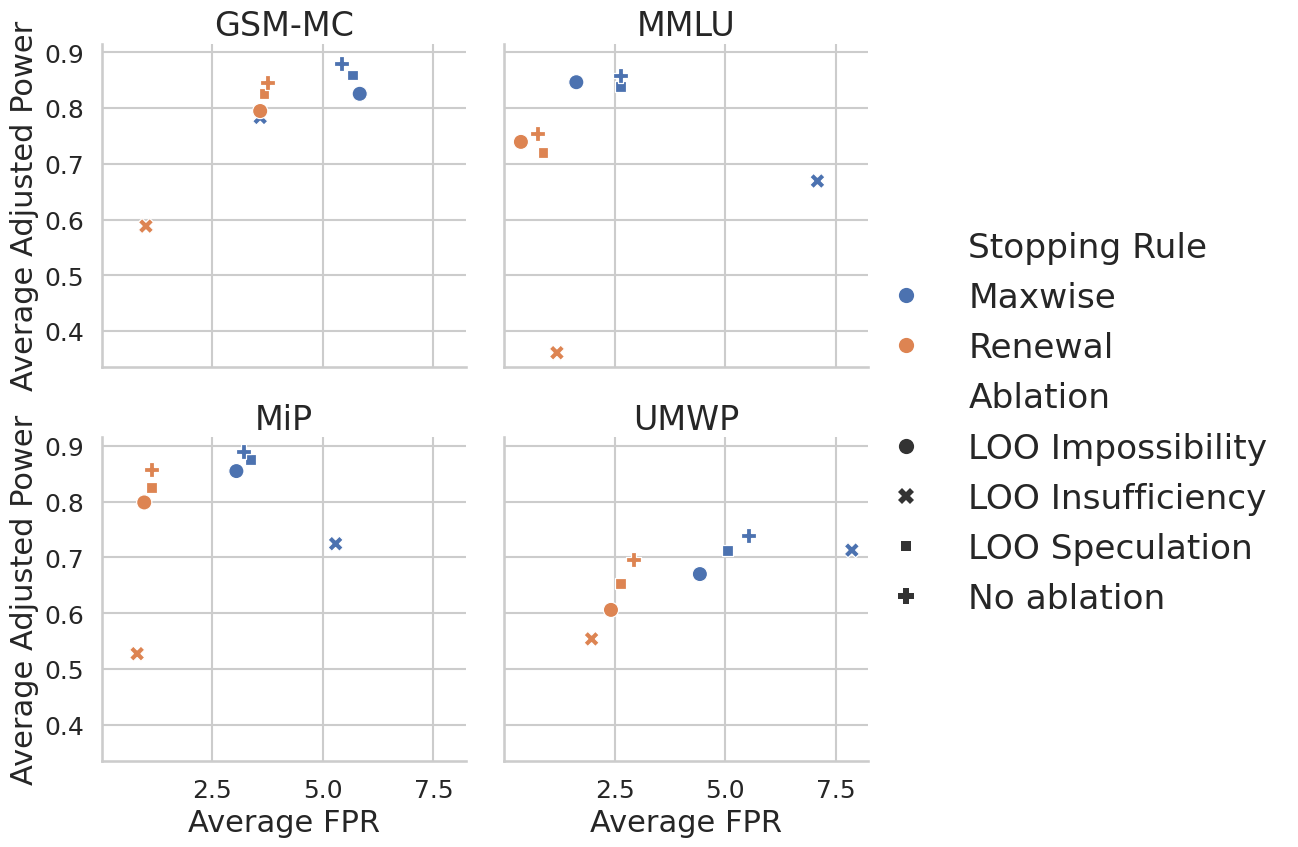

In [21]:
stopping_rule_results_summary = pd.read_csv(base_path + "stopping_rule_results_summary.csv")

# subset to stopping rules to 'Renewal' and 'Maxwise' only, and the lazy interval is 250
stopping_rule_results_summary = stopping_rule_results_summary[
    (stopping_rule_results_summary['stopping_rule'].isin(['Renewal', 'Maxwise'])) &
    (stopping_rule_results_summary['lazy_interval'] == "250") &
    (stopping_rule_results_summary['ablation'].isin(['none', 'loo_Speculation', 'loo_Impossibility', 'loo_Insufficiency']))
]

stopping_rule_results_summary['adjusted_power'] = stopping_rule_results_summary['early_stopping_rate_ill_posed'] / stopping_rule_results_summary['soft_upperbound'] 

stopping_rule_results_summary['ablation'] = (
    stopping_rule_results_summary['ablation']
    .replace({'none': 'No ablation', 'loo_Impossibility': 'LOO Impossibility', 'loo_Insufficiency': 'LOO Insufficiency', 'loo_Speculation': 'LOO Speculation'})
)

# Replace dataset labels before plotting (for facet titles)
stopping_rule_results_summary['dataset'] = (
    stopping_rule_results_summary['dataset']
    .replace(dataset_labels)
)

# rename "stopping_rule" column to "Stopping Rule"
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={'stopping_rule': 'Stopping Rule', 'dataset': 'Dataset', 'ablation': 'Ablation'})


stopping_rule_summary = stopping_rule_results_summary.groupby(
    ['Stopping Rule', 'Dataset', 'Ablation']
).agg(
    avg_fpr=('early_stopping_rate_well_posed', 'mean'),
    avg_adjusted_power=('adjusted_power', 'mean')
).reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

# Global font scaling
sns.set_theme(
    style="whitegrid",
    context="talk",   # larger than default
    font_scale=1.5
)

g = sns.relplot(
    data=stopping_rule_summary,
    x="avg_fpr",
    y="avg_adjusted_power",
    hue="Stopping Rule",
    hue_order=["Maxwise", "Renewal"],
    style="Ablation",
    col="Dataset",
    col_wrap=2,
    kind="scatter",
    s=120,            # slightly larger markers to match fonts
    height=5,
)

# Facet titles
g.set_titles("{col_name}", size=24)

# Axis labels
g.set_axis_labels(
    "Average FPR",
    "Average Adjusted Power",
    fontsize=22
)

# Tick labels
for ax in g.axes.flatten():
    ax.tick_params(axis='both', labelsize=18)


# Layout adjustment to prevent clipping
g.fig.subplots_adjust(top=0.85)
plt.savefig("figs/ablate_keywords.png", dpi=300)
plt.show()

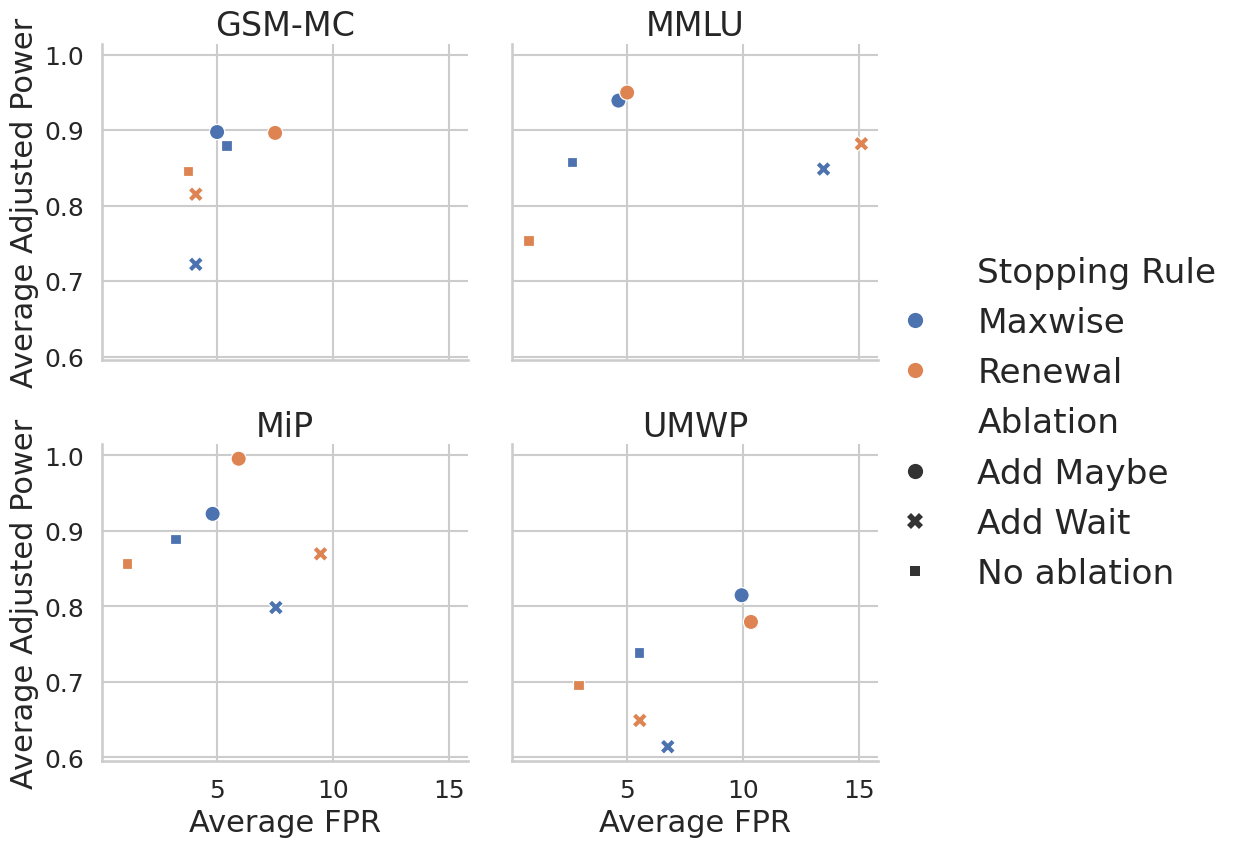

In [22]:
stopping_rule_results_summary = pd.read_csv(base_path + "stopping_rule_results_summary.csv")

# subset to stopping rules to 'Renewal' and 'Maxwise' only, and the lazy interval is 250
stopping_rule_results_summary = stopping_rule_results_summary[
    (stopping_rule_results_summary['stopping_rule'].isin(['Renewal', 'Maxwise'])) &
    (stopping_rule_results_summary['lazy_interval'] == "250") &
    (stopping_rule_results_summary['ablation'].isin(['none', 'add_maybe', 'add_wait']))
]

stopping_rule_results_summary['adjusted_power'] = stopping_rule_results_summary['early_stopping_rate_ill_posed'] / stopping_rule_results_summary['soft_upperbound'] 

stopping_rule_results_summary['ablation'] = (
    stopping_rule_results_summary['ablation']
    .replace({'none': 'No ablation', 'add_maybe': 'Add Maybe', 'add_wait': 'Add Wait'})
)

# Replace dataset labels before plotting (for facet titles)
stopping_rule_results_summary['dataset'] = (
    stopping_rule_results_summary['dataset']
    .replace(dataset_labels)
)

# rename "stopping_rule" column to "Stopping Rule"
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={'stopping_rule': 'Stopping Rule', 'dataset': 'Dataset', 'ablation': 'Ablation'})


stopping_rule_summary = stopping_rule_results_summary.groupby(
    ['Stopping Rule', 'Dataset', 'Ablation']
).agg(
    avg_fpr=('early_stopping_rate_well_posed', 'mean'),
    avg_adjusted_power=('adjusted_power', 'mean')
).reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.relplot(
    data=stopping_rule_summary,
    x="avg_fpr",
    y="avg_adjusted_power",
    hue="Stopping Rule",
    hue_order=["Maxwise", "Renewal"],
    style="Ablation",
    col="Dataset",
    col_wrap=2,
    kind="scatter",
    s=120,            # slightly larger markers to match fonts
    height=5,
)

# Facet titles
g.set_titles("{col_name}", size=24)

# Axis labels
g.set_axis_labels(
    "Average FPR",
    "Average Adjusted Power",
    fontsize=22
)

# Tick labels
for ax in g.axes.flatten():
    ax.tick_params(axis='both', labelsize=18)

# Layout adjustment to prevent clipping
g.fig.subplots_adjust(top=0.85)
plt.savefig("figs/ablate_additional_keywords.png", dpi=300)
plt.show()

Now we investigate the impact of size of lazy intervals used in the Renewal and Maxwise stopping rules.

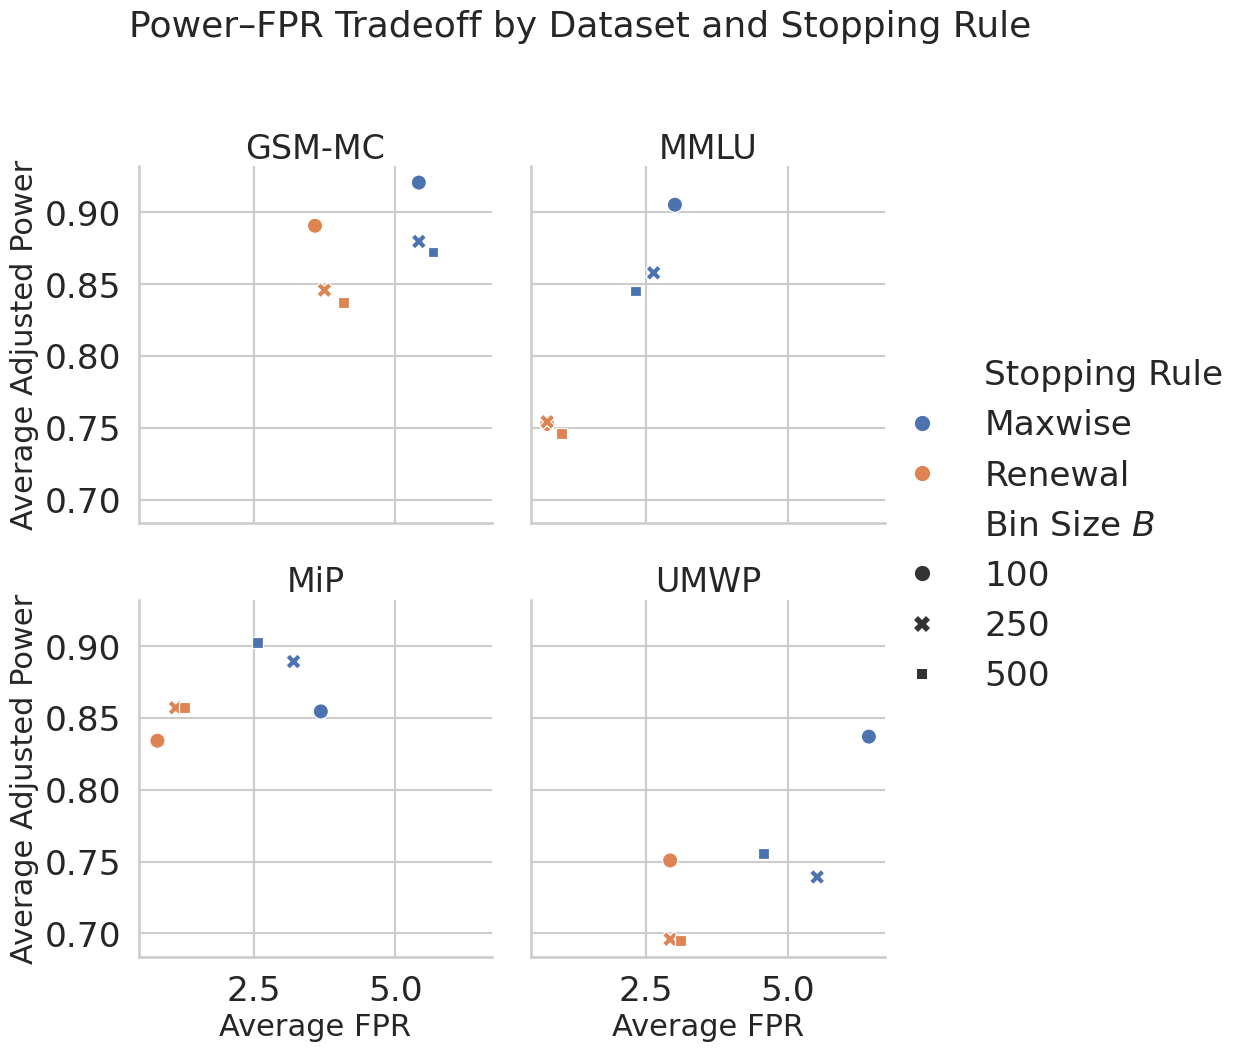

In [23]:
stopping_rule_results_summary = pd.read_csv(base_path + "stopping_rule_results_summary.csv")
# subset to stopping rules to 'Renewal' and 'Maxwise' only, and the ablation is "none"
stopping_rule_results_summary = stopping_rule_results_summary[
    (stopping_rule_results_summary['stopping_rule'].isin(['Renewal', 'Maxwise'])) &
    (stopping_rule_results_summary['ablation'] == "none")
]


stopping_rule_results_summary['adjusted_power'] = stopping_rule_results_summary['early_stopping_rate_ill_posed'] / stopping_rule_results_summary['soft_upperbound'] 

# Replace dataset labels before plotting (for facet titles)
stopping_rule_results_summary['dataset'] = (
    stopping_rule_results_summary['dataset']
    .replace(dataset_labels)
)

# rename "stopping_rule" column to "Stopping Rule"
stopping_rule_results_summary = stopping_rule_results_summary.rename(columns={'stopping_rule': 'Stopping Rule', 'dataset': 'Dataset', 'lazy_interval': 'Bin Size $B$'})

stopping_rule_summary = stopping_rule_results_summary.groupby(
    ['Stopping Rule', 'Dataset', 'Bin Size $B$']
).agg(
    avg_fpr=('early_stopping_rate_well_posed', 'mean'),
    avg_adjusted_power=('adjusted_power', 'mean'),
    avg_percentage_saved=('avg_percentage_saved_ill_posed', 'mean')
).reset_index()


g = sns.relplot(
    data=stopping_rule_summary,
    x="avg_fpr",
    y="avg_adjusted_power",
    hue="Stopping Rule",
    hue_order=["Maxwise", "Renewal"],        # optional, keeps consistent order
    style="Bin Size $B$",
    style_order=["100", "250", "500"],      # if desired
    col="Dataset",
    col_wrap=2,
    kind="scatter",
    s=120,            # slightly larger markers to match fonts
    height=5,
)

# Facet titles
g.set_titles("{col_name}", size=24)

# Axis labels
g.set_axis_labels(
    "Average FPR",
    "Average Adjusted Power", fontsize=22
)

# Suptitle
g.fig.suptitle(
    "Power–FPR Tradeoff by Dataset and Stopping Rule",
    fontsize=26,
    y=1.08
)
plt.savefig("figs/ablate_intervals.png", dpi=300)
plt.show()

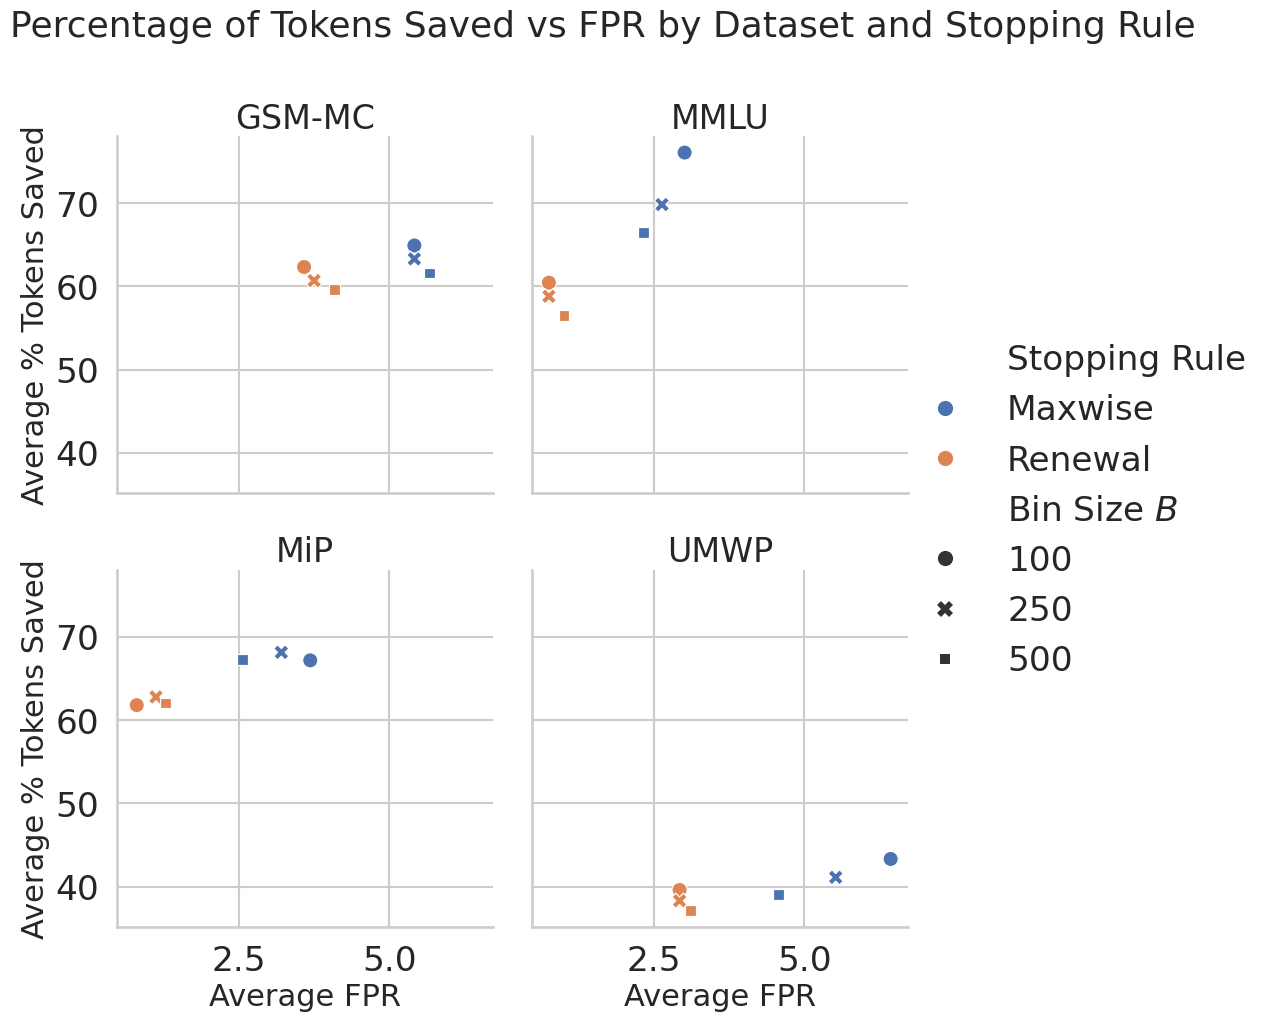

In [24]:
g = sns.relplot(
    data=stopping_rule_summary,
    x="avg_fpr",
    y="avg_percentage_saved",
    hue="Stopping Rule",
    hue_order=["Maxwise", "Renewal"],        # optional, keeps consistent order
    style="Bin Size $B$",
    style_order=["100", "250", "500"],      # if desired
    col="Dataset",
    col_wrap=2,
    kind="scatter",
    s=120,            # slightly larger markers to match fonts
    height=5,
)


g.set_titles("{col_name}", size=24)
g.set_axis_labels("Average FPR", "Average % Tokens Saved", fontsize=22)
plt.suptitle("Percentage of Tokens Saved vs FPR by Dataset and Stopping Rule", y=1.05, fontsize=26)
plt.savefig("figs/ablate_intervals_efficiency.png", dpi=300)
plt.show()